In [1]:
import sys
import os
import yaml
import numpy as np
#import pandas
from io import StringIO
import pandas as pd
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

In [7]:
# Get paths from configuration file
case = 'whidbey'
with open(f'../../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# loading_dir = pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/run_scenarios/input_setting")
runs = [*ssm['paths']['nutrient_loading_inputs']]
loading_files = {}
# ssm['paths']['nutrient_loading_inputs']['3j']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3j/coldstart/inputs/ssm_pnt_wq.dat'
# ssm['paths']['nutrient_loading_inputs']['3k']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3k/coldstart/inputs/ssm_pnt_wq.dat'
ssm['paths']['nutrient_loading_inputs']['4b']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4b/coldstart/inputs/ssm_pnt_wq.dat'
ssm['paths']['nutrient_loading_inputs']['4c']='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/4c/coldstart/inputs/ssm_pnt_wq.dat'
runs = [*ssm['paths']['nutrient_loading_inputs']]
for run in runs:
    print(ssm['paths']['nutrient_loading_inputs'][run])

/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/WQM/WQM/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/WQM_REF/WQM_REF/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3b/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3e/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3f/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3g/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3h/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3i/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3j/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3k/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3c/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3l/hotstart

# plot the output from debug statements in my script

In [4]:
dbdf = pd.read_excel('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/run_scenarios/input_setting/debug.xlsx')
dbdf=dbdf.drop(columns=['Unnamed: 0'])
[*dbdf]

['nh4_new',
 'no3_new',
 'nh4_of100',
 'no3no2_of100',
 'nh4_North',
 'no3no2_North']

In [36]:
dbdf['nh4_combo']=dbdf['nh4_of100']+ dbdf['nh4_North']
dbdf['no3no2_combo']=dbdf['no3no2_of100']+ dbdf['no3no2_North']

<AxesSubplot:>

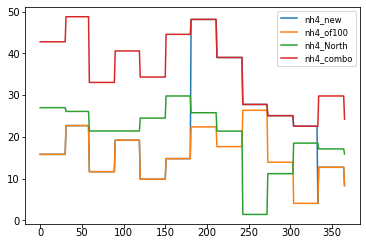

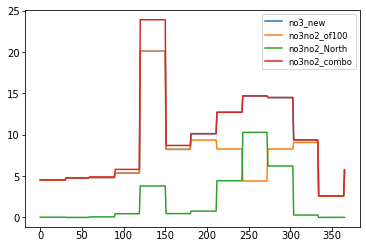

In [37]:
dbdf[['nh4_new','nh4_of100','nh4_North','nh4_combo']].plot()
dbdf[['no3_new','no3no2_of100','no3no2_North','no3no2_combo']].plot()

### The red line is the combination of Everett North and South values. It covers the blue line, which is the value from the input file, during the summer....showing that the input file script is working properly

In [48]:
in_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-spreadsheets')
source_locations = pd.read_excel(in_dir/'ssm_pnt_wq_station_info.xlsx',index_col='Unnamed: 0')
source_names=source_locations.index.tolist()

In [49]:
inputs = {}
for run in runs:
    with open(ssm['paths']['nutrient_loading_inputs'][run]) as f:
        # The parsing logic here is is derived from the linkage instructions for the
        # model and direct examination of the source code

        # The first line does not contain important information and is treated only like
        # a filetype magic
        next(f)

        # The total number of discharge nodes
        num_qs = int(next(f))
        # All the node numbers with discharges
        #nodes = np.loadtxt([next(f) for l in range(num_qs)], comments='!', dtype=int)
        node_raw = StringIO('\n'.join([next(f) for l in range(num_qs)]))
        node_df = pd.read_csv(node_raw, sep='\s+!\s+', names=('Node','Comment'),
                              dtype={'Node':np.int64,'Comment':object}, engine='python')
        node_df.set_index('Node', inplace=True)
        nodes = node_df.index.to_numpy()
        # Depth distribution fractions into each node. Skipping the first (node count) column
        vqdist = np.loadtxt([next(f) for l in range(num_qs)])[:,1:]

        num_times = int(next(f))

        # Initialize storage arrays
        times = np.zeros(num_times)
        qs = np.zeros((num_times, num_qs))
        # State variables in the order they are present in the file. These are also going
        # to be the NetCDF variable names
        statevars = ('discharge', 'temp', 'salt', 'tss',  'alg1', 'alg2', 'alg3', 'zoo1',
                                  'zoo2', 'ldoc', 'rdoc', 'lpoc', 'rpoc', 'nh4',  'no32',
                                  'urea', 'ldon', 'rdon', 'lpon', 'rpon', 'po4',  'ldop',
                                  'rdop', 'lpop', 'rpop', 'pip',  'cod',  'doxg', 'psi',
                                  'dsi',  'alg1p','alg2p','alg3p','dic',  'talk')
        inputs[run] = {}
        for v in statevars:
            inputs[run][v] = np.zeros((num_times, num_qs))

        for t in range(num_times):
            times[t] = float(next(f))
            for v in statevars:
                inputs[run][v][t,:] = np.loadtxt([next(f)])

In [50]:
total_nitrogen={}
total_annual_nitrogen={}
loading={}
for run in runs:
    loading[run] = (inputs[run]['discharge'] * (inputs[run]['nh4'] + inputs[run]['no32']) * 24 * 3600)/1000 #m3/s*mg/l -> kg/day
    total_nitrogen[run]=loading[run].sum(axis=0) # annual loading over 366 days (g/year)
    total_annual_nitrogen[run] = total_nitrogen[run].sum() # g/year -> kg/year

In [51]:
locations = ['  Everett Snohomish', '  OF100']

In [52]:
print('idices: ', source_names.index(locations[0]),source_names.index(locations[1]))

idices:  201 212


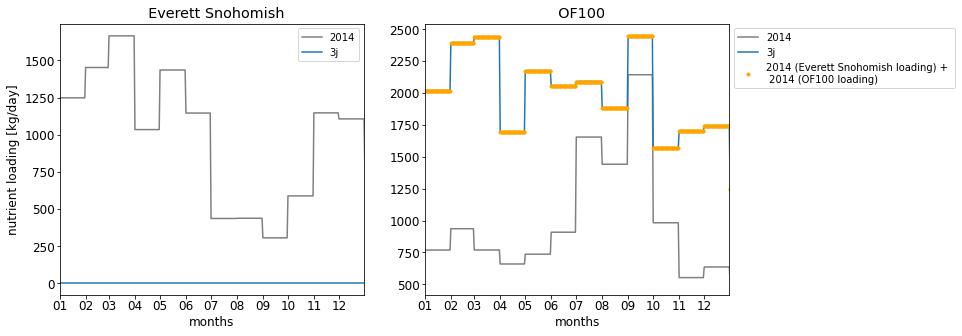

In [63]:
run_id = "3j"
# create date vector
dti = pd.date_range("2014-01-01", periods=366, freq="d")
dti[-1]
mpl.rc('font', size = 12, family='sans-serif', weight='normal', style='normal')
fig,ax=plt.subplots(1,2, figsize=(12,5),
   gridspec_kw={
   'width_ratios': [1,1],
   'height_ratios': [1], 
   'wspace': 0.2,
   'hspace': 0.5}
)
for idx in [0,1]:
    ax[idx].plot(dti,loading["wqm_baseline"][:,[source_names.index(locations[idx])]], color='grey', label="2014")
    ax[idx].plot(dti,loading[run_id][:,[source_names.index(locations[idx])]], label=run_id)
    ax[idx].set_title(locations[idx])
    ax[idx].set_xlim(np.datetime64('2014-01-01'), np.datetime64('2014-12-31'))
    # set x-ticklabels to the first day of the month
    ax[idx].xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax[idx].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
# take the difference of Everett Snohomish and add it to OF100
delta_north = loading["wqm_baseline"][:,[source_names.index(locations[0])]]-loading[run_id][:,[source_names.index(locations[0])]]
ax[1].plot(dti,loading["wqm_baseline"][:,[source_names.index(locations[1])]]+delta_north,'.', color='orange',label='2014 (Everett Snohomish loading) + \n 2014 (OF100 loading)')
ax[0].legend()
ax[1].legend(bbox_to_anchor=(1,1),loc="upper left")
ax[0].set_xlabel('months')
ax[1].set_xlabel('months')
ax[0].set_ylabel('nutrient loading [kg/day]')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/f'ssm_pnt_wq_{run_id}_loadings.png',
                        bbox_inches='tight',format='png')


In [32]:
ssm['paths']['graphics']

'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/'

In [30]:
in_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/run_scenarios/input_setting')

In [31]:
scenario_setting=pd.read_excel(in_dir/'run_strategy.xlsx',index_col=0,sheet_name='3j')

In [6]:
scenario_setting.sum()

Unnamed: 1                         Agate East  Agate West  Anderson east  Ander...
type                             RiverRiverRiverRiverRiverRiverRiverRiverRiverR...
node_id                                                                    2901526
Lat                                                                   12370.385375
Lon                                                                   -31802.22129
Depth [km]                                                                9.989324
layer_distribute                 Surface3Surface3Surface3Surface3Surface3Surfac...
Region                             South_Sound  South_Sound  South_Sound  South...
country                            United States  United States  United States ...
NH4[kg/year]                                                       25354056.180308
NO3NO2[kg/year]                                                    26759513.324702
N-load [kg/year] (Baseline)                                        52113569.508102
N-lo

In [32]:
scenario_setting_orig=pd.read_excel(in_dir/'run_strategy.xlsx',index_col=0)
scenario_setting_orig.sum()

Unnamed: 1                         Agate East  Agate West  Anderson east  Ander...
type                             RiverRiverRiverRiverRiverRiverRiverRiverRiverR...
node_id                                                                    2901526
Lat                                                                   12370.385375
Lon                                                                   -31802.22129
Depth [km]                                                                9.989324
layer_distribute                 Surface3Surface3Surface3Surface3Surface3Surfac...
Region                             South_Sound  South_Sound  South_Sound  South...
country                            United States  United States  United States ...
NH4[kg/year]                                                       25014665.038308
NO3NO2[kg/year]                                                    26734305.911622
N-load [kg/year] (Baseline)                                        51748970.953002
N-lo

In [14]:
scenario_setting.loc[scenario_setting['Unnamed: 1']=='  Everett Snohomish']

,Unnamed: 1,type,node_id,Lat,Lon,Depth [km],layer_distribute,Region,country,NH4[kg/year],...,N-load % Difference,Anthropogenic.1,flow_yearly_sum [m3],flow_yearly_mean [m3],NO3NO2-yearly_avg_conc [mg/L],NH4-yearly_avg_conc [mg/L],Average Annual TIN (mg/L),calculated yearly N-loading,percent loading diff,3j
201,Everett Snohomish,Point Source,12179,48.004747,-122.1769,0.00592,Layer 10,Whidbey,United States,339391.142,...,-1.0,NaN,188.1732,0.514134,2.244,20.432,22.676,367662.47,0.01,0


In [16]:
scenario_setting_orig.loc[scenario_setting_orig['Unnamed: 1']=='  Everett Snohomish']

,Unnamed: 1,type,node_id,Lat,Lon,Depth [km],layer_distribute,Region,country,NH4[kg/year],...,4c,4d,4e,4f,4g,4h,4i,4j,4k,4l
201,Everett Snohomish,Point Source,12179,48.004747,-122.1769,0.00592,Layer 10,Whidbey,United States,339391.142,...,1.0,1.0,1.0,1,1.0,1,1.0,1,1.0,1


In [15]:
scenario_setting.loc[scenario_setting['Unnamed: 1']=='  OF100']

,Unnamed: 1,type,node_id,Lat,Lon,Depth [km],layer_distribute,Region,country,NH4[kg/year],...,N-load % Difference,Anthropogenic.1,flow_yearly_sum [m3],flow_yearly_mean [m3],NO3NO2-yearly_avg_conc [mg/L],NH4-yearly_avg_conc [mg/L],Average Annual TIN (mg/L),calculated yearly N-loading,percent loading diff,3j
212,OF100,Point Source,9143,47.968343,-122.24931,0.076072,Layer 10,Whidbey,United States,599358.6167,...,-2.0,0.0,370.0271,1.011003,9.755,36.273,46.028,733576.3753,-0.01,1


In [20]:
scenario_setting_orig.loc[scenario_setting_orig['Unnamed: 1']=='  OF100']['NO3NO2-yearly_avg_conc [mg/L]'] - scenario_setting.loc[scenario_setting['Unnamed: 1']=='  OF100']['NO3NO2-yearly_avg_conc [mg/L]'] 

212   -2.244
Name: NO3NO2-yearly_avg_conc [mg/L], dtype: float64

In [22]:
scenario_setting_orig.loc[scenario_setting_orig['Unnamed: 1']=='  OF100']['NO3NO2-yearly_avg_conc [mg/L]]

212    7.511
Name: NO3NO2-yearly_avg_conc [mg/L], dtype: float64

In [33]:
[scenario_setting_orig.loc[scenario_setting_orig['Unnamed: 1']=='  OF100'][var] - scenario_setting.loc[scenario_setting['Unnamed: 1']=='  OF100'][var] for var in var_list]

[212   -339391.142
 Name: NH4[kg/year], dtype: float64,
 212   -25207.41308
 Name: NO3NO2[kg/year], dtype: float64,
 212    0.0
 Name: N-load [kg/year] (Baseline), dtype: float64,
 212    0.0
 Name: N-load [kg/year] (Reference), dtype: float64,
 212    1.0
 Name: N-load % Difference, dtype: float64,
 212   NaN
 Name: Anthropogenic.1, dtype: float64,
 212    0.0
 Name: flow_yearly_sum [m3], dtype: float64,
 212    0.0
 Name: flow_yearly_mean [m3], dtype: float64,
 212   -2.244
 Name: NO3NO2-yearly_avg_conc [mg/L], dtype: float64,
 212   -20.432
 Name: NH4-yearly_avg_conc [mg/L], dtype: float64,
 212   -22.676
 Name: Average Annual TIN (mg/L), dtype: float64,
 212   -367662.47
 Name: calculated yearly N-loading, dtype: float64]

In [26]:
[*scenario_setting_orig.loc[scenario_setting_orig['Unnamed: 1']=='  OF100']]

['Unnamed: 1',
 'type',
 'node_id',
 'Lat',
 'Lon',
 'Depth [km]',
 'layer_distribute',
 'Region',
 'country',
 'NH4[kg/year]',
 'NO3NO2[kg/year]',
 'N-load [kg/year] (Baseline)',
 'N-load [kg/year] (Reference)',
 'Anthropogenic',
 'Unnamed: 15',
 'N-load % Difference',
 'Anthropogenic.1',
 'flow_yearly_sum [m3]',
 'flow_yearly_mean [m3]',
 'NO3NO2-yearly_avg_conc [mg/L]',
 'NH4-yearly_avg_conc [mg/L]',
 'Average Annual TIN (mg/L)',
 'calculated yearly N-loading',
 'percent loading diff',
 '1a',
 '1b',
 '1c',
 '1d',
 '1e',
 '2a',
 '2b',
 '3a',
 '3b',
 '3c',
 '3e',
 '3f',
 '3g',
 '3h',
 '3i',
 '3l',
 '3m',
 '4a',
 '4b',
 '4c',
 '4d',
 '4e',
 '4f',
 '4g',
 '4h',
 '4i',
 '4j',
 '4k',
 '4l']

In [27]:
var_list = [
'NH4[kg/year]',
 'NO3NO2[kg/year]',
 'N-load [kg/year] (Baseline)',
 'N-load [kg/year] (Reference)',
 'N-load % Difference',
 'Anthropogenic.1',
 'flow_yearly_sum [m3]',
 'flow_yearly_mean [m3]',
 'NO3NO2-yearly_avg_conc [mg/L]',
 'NH4-yearly_avg_conc [mg/L]',
 'Average Annual TIN (mg/L)',
 'calculated yearly N-loading']